<a href="https://colab.research.google.com/github/SivanisIyer/Lung-Cancer-SVM/blob/main/new_Lung_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
BASE_PATH = "/content/drive/MyDrive/WORK/LUNG CANCER-DS"


In [21]:
import os

print("Base path exists:", os.path.exists(BASE_PATH))

class_names = sorted(os.listdir(BASE_PATH))
print("Classes found:", class_names)

for cls in class_names:
    cls_path = os.path.join(BASE_PATH, cls)
    imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    print(f"{cls}: {len(imgs)} images")


Base path exists: True
Classes found: ['LUAD', 'LUSC']
LUAD: 5022 images
LUSC: 5000 images


# **Image Preprocessing (Resize + Normalize)**

In [22]:
import cv2
import numpy as np

IMG_SIZE = 512

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0

    return img


In [23]:
# Pick one sample image
sample_class = class_names[0]
sample_img = os.listdir(os.path.join(BASE_PATH, sample_class))[0]
sample_path = os.path.join(BASE_PATH, sample_class, sample_img)

img = preprocess_image(sample_path)
print("Image shape:", img.shape)
print("Pixel range:", img.min(), "to", img.max())


Image shape: (512, 512, 3)
Pixel range: 0.0 to 1.0


# Patch Extraction (128 × 128)

In [24]:
PATCH_SIZE = 128

def extract_patches(img, patch_size=128):
    patches = []
    h, w, _ = img.shape

    for y in range(0, h - patch_size + 1, patch_size):
        for x in range(0, w - patch_size + 1, patch_size):
            patch = img[y:y+patch_size, x:x+patch_size]
            patches.append(patch)

    return patches


In [25]:
patches = extract_patches(img)

print("Total patches extracted:", len(patches))
print("One patch shape:", patches[0].shape)


Total patches extracted: 16
One patch shape: (128, 128, 3)


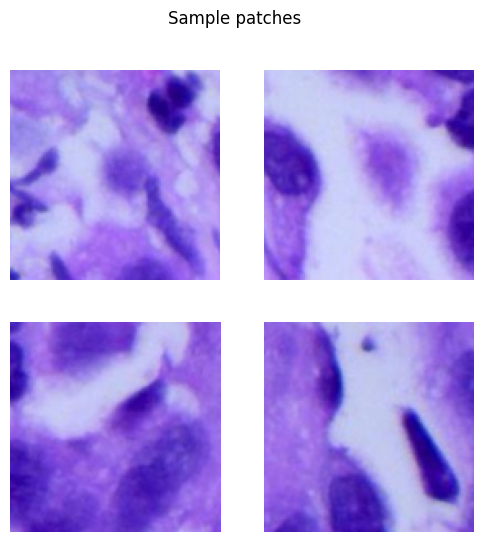

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(patches[i])
    plt.axis("off")
plt.suptitle("Sample patches")
plt.show()


# **CNN as a Feature Extractor**

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

def build_feature_extractor():
    inputs = Input(shape=(128, 128, 3))

    x = Conv2D(32, 3, activation='relu')(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, 3, activation='relu')(x)
    x = GlobalAveragePooling2D()(x)  # 👈 converts feature maps to vector

    model = Model(inputs, x)
    return model

cnn = build_feature_extractor()
cnn.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from tqdm import tqdm

MAX_IMAGES_PER_CLASS = 300   # you can increase later
X_features = []
y_labels = []

for cls in class_names:
    cls_path = os.path.join(BASE_PATH, cls)
    label = class_names.index(cls)

    img_list = os.listdir(cls_path)
    count = 0

    print(f"Processing class: {cls}")

    for img_name in tqdm(img_list):
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        img_path = os.path.join(cls_path, img_name)
        img = preprocess_image(img_path)
        if img is None:
            continue

        patches = extract_patches(img)

        for patch in patches:
            feat = cnn.predict(
                np.expand_dims(patch, axis=0),
                verbose=0
            )[0]

            X_features.append(feat)
            y_labels.append(label)

        count += 1
        if count >= MAX_IMAGES_PER_CLASS:
            break


Processing class: LUAD


  6%|▌         | 299/5023 [09:32<2:30:50,  1.92s/it]


Processing class: LUSC


  6%|▌         | 299/5000 [09:22<2:27:18,  1.88s/it]


In [29]:
print("X_features shape:", np.array(X_features).shape)
print("y_labels shape:", np.array(y_labels).shape)


X_features shape: (9600, 128)
y_labels shape: (9600,)


# **SVM on patch training**

In [30]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        probability=True
    ))
])

print("Training SVM...")
svm_model.fit(X_features, y_labels)
print("✅ SVM training completed")


Training SVM...
✅ SVM training completed


# **Attention / Weighted Patch Voting**

In [31]:
def predict_image_weighted(img_path, cnn, svm_model):
    img = preprocess_image(img_path)
    if img is None:
        return None

    patches = extract_patches(img)

    features = []
    for patch in patches:
        feat = cnn.predict(
            np.expand_dims(patch, axis=0),
            verbose=0
        )[0]
        features.append(feat)

    features = np.array(features)

    # Patch-level probabilities
    probs = svm_model.predict_proba(features)
    preds = np.argmax(probs, axis=1)

    # Attention weights = confidence
    weights = np.max(probs, axis=1)

    # Weighted voting
    final_pred = np.argmax(np.bincount(preds, weights))
    return final_pred


In [32]:
test_img_path = os.path.join(
    BASE_PATH,
    class_names[0],
    os.listdir(os.path.join(BASE_PATH, class_names[0]))[0]
)

pred = predict_image_weighted(test_img_path, cnn, svm_model)
print("Predicted class index:", pred)
print("Predicted class name:", class_names[pred])


Predicted class index: 0
Predicted class name: LUAD


# **Image-level Evaluation**

In [34]:
correct = 0
total = 0
MAX_TEST_IMAGES = 50

for cls in class_names:
    cls_path = os.path.join(BASE_PATH, cls)
    true_label = class_names.index(cls)

    tested = 0
    for img_name in os.listdir(cls_path):
        if not img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            continue

        img_path = os.path.join(cls_path, img_name)
        pred = predict_image_weighted(img_path, cnn, svm_model)

        if pred == true_label:
            correct += 1
        total += 1

        tested += 1
        if tested >= MAX_TEST_IMAGES:
            break

accuracy = (correct / total) * 100
print("✅ Image-level Accuracy:", round(accuracy, 2), "%")


✅ Image-level Accuracy: 96.0 %
